In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

## a) load/merge data and visualize logerror

In [51]:
# load data into DataFrames
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv("train.csv", keep_default_na=False, na_values=[""])
properties_df = pd.read_csv("properties.csv", keep_default_na=False, na_values=[""])

df = pd.merge(train_df, properties_df, on='id')
# [31725 rows x 60 columns]
#X = dataset.iloc[:, [3, 4]].values









In [52]:
# eliminate outliers
min_value, max_value = np.percentile(df['logerror'], [1, 99])

df['logerror'] = np.where(df['logerror']>max_value, max_value, df['logerror'])   
df['logerror'] = np.where(df['logerror']<min_value, min_value, df['logerror']) 

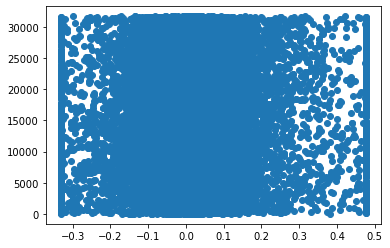

In [53]:
# scatter of logerr
fig, ax = plt.subplots()
ax.scatter(df['logerror'], df['logerror'].index)
# plt.show()

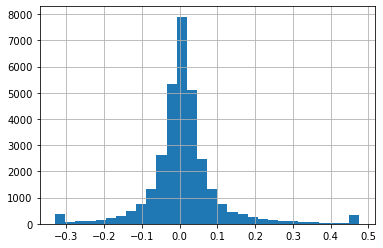

In [54]:
# histogram of logerr
# # df.logerror.hist()
df.logerror.hist(bins=30)

## b) data cleaning

In [55]:
# build new data frame
num = len(df)
data = pd.DataFrame({'column_name': list(df.columns), 'missing_count': list(df.isnull().sum())})
data['missing_ratio'] = data.iloc[:,1].values/num
print(data)

                     column_name  missing_count  missing_ratio
0                             id              0       0.000000
1                       logerror              0       0.000000
2                transactiondate              0       0.000000
3          airconditioningtypeid          21563       0.679685
4       architecturalstyletypeid          31628       0.996942
5                   basementsqft          31711       0.999559
6                    bathroomcnt              0       0.000000
7                     bedroomcnt              0       0.000000
8            buildingclasstypeid          31717       0.999748
9          buildingqualitytypeid          11488       0.362112
10             calculatedbathnbr            414       0.013050
11                    decktypeid          31502       0.992971
12      finishedfloor1squarefeet          29381       0.926115
13  calculatedfinishedsquarefeet            228       0.007187
14          finishedsquarefeet12           1647       0

In [56]:
# fill missing data
df.update(df.fillna(df.mean(), inplace=True))
print(df)

             id  logerror transactiondate  airconditioningtypeid  \
0      14366692   -0.1684          1/1/16               1.809683   
1      14739064   -0.0030          1/2/16               1.809683   
2      10854446    0.3825          1/3/16               1.809683   
3      11672170   -0.0161          1/3/16               1.000000   
4      12524288   -0.0419          1/3/16               1.809683   
...         ...       ...             ...                    ...   
31720  12756771    0.0658        12/30/16               1.809683   
31721  11295458   -0.0294        12/30/16               1.000000   
31722  11308315    0.0070        12/30/16               1.000000   
31723  11703478    0.0431        12/30/16               1.809683   
31724  12566293    0.4207        12/30/16               1.809683   

       architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                      7.453608    670.571429          3.5         4.0   
1                      7.453608    

## c) univariate analysis

id                              0.006562
airconditioningtypeid           0.006328
architecturalstyletypeid       -0.001234
basementsqft                    0.005239
bathroomcnt                     0.033445
bedroomcnt                      0.032168
buildingclasstypeid                  NaN
buildingqualitytypeid          -0.001840
calculatedbathnbr               0.034345
decktypeid                           NaN
finishedfloor1squarefeet        0.000807
calculatedfinishedsquarefeet    0.042841
finishedsquarefeet12            0.039504
finishedsquarefeet13            0.012608
finishedsquarefeet15            0.014687
finishedsquarefeet50            0.000621
finishedsquarefeet6            -0.000656
fips                            0.007863
fireplacecnt                    0.005099
fullbathcnt                     0.032986
garagecarcnt                   -0.000039
garagetotalsqft                 0.005227
heatingorsystemtypeid          -0.019511
latitude                        0.003277
longitude       

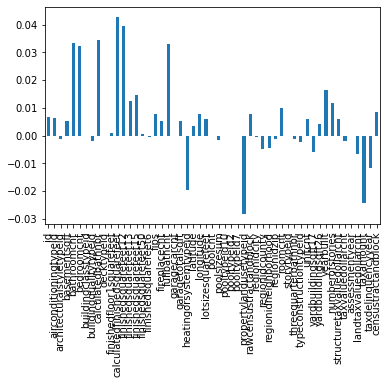

In [57]:
# make bar chart
correlation = df.corr()['logerror']
neg = correlation.index.isin(['logerror'])
correlation = correlation[~neg]
print(correlation)
correlation.plot.bar()

# explain reason
This bar plot above indicates that there is generally either a positive correlation and negative correlation between the logerror and each variable. The few variables without correlation values indicate that the association between those variables and logerror is not obvious or is hardly observable. The variables with positive correlation values indicate that large values of logerror corresponds to large values of those variables, and vice versa. While the variables with negative correlation values indicate that large values of logerror corresponds to small values of those variables, and vice versa.

## d) non-linear regression model

In [58]:
# drop categorical features 
# ("hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag") 
# drop "id" and "transactiondate"
df.drop(['id','transactiondate'], axis=1, inplace=True)
df.fillna(df.mean(), inplace=True)
print(df)

       logerror  airconditioningtypeid  architecturalstyletypeid  \
0       -0.1684               1.809683                  7.453608   
1       -0.0030               1.809683                  7.453608   
2        0.3825               1.809683                  7.453608   
3       -0.0161               1.000000                  7.453608   
4       -0.0419               1.809683                  7.453608   
...         ...                    ...                       ...   
31720    0.0658               1.809683                  7.453608   
31721   -0.0294               1.000000                  7.453608   
31722    0.0070               1.000000                  7.453608   
31723    0.0431               1.809683                  7.453608   
31724    0.4207               1.809683                  7.453608   

       basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0        670.571429          3.5         4.0                  4.0   
1        670.571429          1.0         2.0 

In [68]:
# split and train
X = df.select_dtypes('float').values[:,1:]
y = df.select_dtypes('float').values[:,0]




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Already normalized data**
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

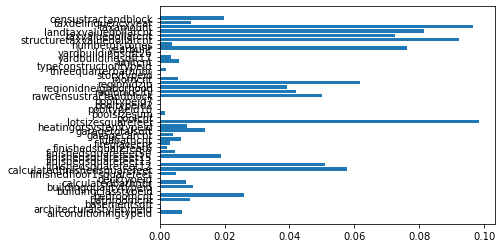

Mean Squared Error: 0.010773740173083314


In [69]:
# report importances and mse
plt.barh(df.select_dtypes('float').columns[1:], regressor.feature_importances_)
plt.show()

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

## e) KFold

In [70]:
# KFold, k = 5
X_cv = df.select_dtypes('float').values[:500,1:]
y_cv = df.select_dtypes('float').values[:500,0]
model = RandomForestRegressor(n_estimators=20, random_state=1)
cv = KFold(n_splits=5, random_state=1, shuffle=True) #default is 5 (redundant)
scores = cross_val_score(model, X_cv, y_cv, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
print('Mean Squared Error_CV:', np.mean(np.absolute(scores)))

Mean Squared Error_CV: 0.014292075903614952


In [71]:
# Run d2 for 100 times
import random

for i in range(100):
    seed = random.randint(0,99)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.transform(X_test)

    regressor = RandomForestRegressor(n_estimators=20, random_state=seed)
    regressor.fit(X_train, y_train)
    y_prd = regressor.predict(X_test)
    print('random_seed: ',seed,'MSE:', metrics.mean_squared_error(y_test, y_prd))

random_seed:  49 MSE: 0.010374547672181215
random_seed:  64 MSE: 0.010468170321508635
random_seed:  27 MSE: 0.010738558893648883
random_seed:  49 MSE: 0.010374547672181215
random_seed:  40 MSE: 0.010652433594255526
random_seed:  29 MSE: 0.010615661260027666
random_seed:  49 MSE: 0.010374547672181215
random_seed:  27 MSE: 0.010738558893648883
random_seed:  18 MSE: 0.010661646303790831
random_seed:  75 MSE: 0.010056237810833929
random_seed:  72 MSE: 0.010346488533182234
random_seed:  7 MSE: 0.010596493018438952
random_seed:  91 MSE: 0.010704934797804322
random_seed:  43 MSE: 0.010759998565866298
random_seed:  38 MSE: 0.010741879316798836
random_seed:  77 MSE: 0.010849221227234375
random_seed:  84 MSE: 0.010447766787825772
random_seed:  69 MSE: 0.010847690855126105
random_seed:  49 MSE: 0.010374547672181215
random_seed:  9 MSE: 0.010424234396700042
random_seed:  61 MSE: 0.010612658205591279
random_seed:  23 MSE: 0.010710105239384803
random_seed:  93 MSE: 0.010859594909032997
random_seed: 

There is not a huge different between the MSE with different random seeds. Cross_validation would be good here because it would build K different models so we are able to make prediction on all the data. Confidence in the alogrithm would also be built with cross-validation as confidence in the algorithm is currently weak.